# US Data Charting
This workbooks analyzes and plots the latest US States data from the [COVID Tracking project](https://covidtracking.com/).

In [1]:
from datetime import datetime, timedelta, timezone
import dateutil.parser as du_parser
import pandas as pd
import eloader as el
import eplotter as ep

# load from the data loader helper
(df_us_daily, df_us_states_daily, df_us_states_latest) = el.load_covidtracking_us_data()
(df_world_daily) = el.load_opencovid19_data()

# fuse data to get the latest-and-greatest
def fuse_sources(df_world, df_us):
    # start from Country-wide world data from OpenCovid-19, removing regional data (only country data is left)
    df = df_world[df_world['RegionCode'].isna()]
    df = df.drop(columns=['RegionCode', 'RegionName'])

    # overwrite the latest US data from the Covid Tracking Project (US daily)
    df = df[df['CountryCode'] != 'US']  # remove US data
    df = pd.concat([df, df_us])   # add daily US data from Covid Tracking
    return df

df_fused_daily = fuse_sources(df_world_daily, df_us_daily)

https://covidtracking.com/api/us/daily.csv: hack: setting the US population count to 329064917
https://covidtracking.com/api/us/daily.csv: non-canonical cols: HospitalizedTotal, InICU, InICUTotal, OnVentilator, OnVentilatorTotal
https://covidtracking.com/api/states/daily.csv: non-canonical cols: HospitalizedTotal, InICU, InICUTotal, OnVentilator, OnVentilatorTotal
https://covidtracking.com/api/states.csv: non-canonical cols: HospitalizedTotal, InICU, InICUTotal, OnVentilator, OnVentilatorTotal
https://open-covid-19.github.io/data/data.csv: non-canonical cols: Latitude, Longitude


## US Aggregate

Confirmed cases in the US. Other countries shown as references.

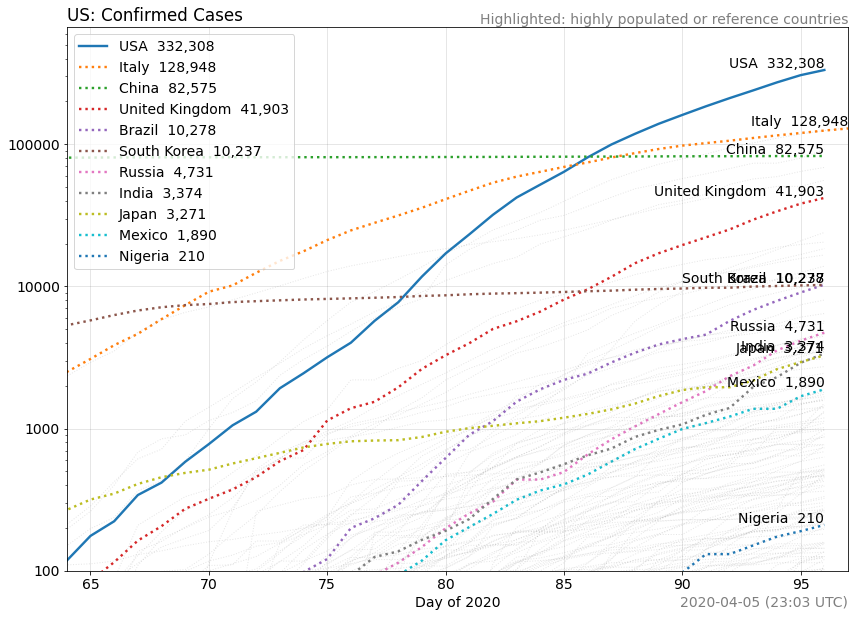

In [2]:
# plot, ranked by Confirmed cases
ranked_countries_by_confirmed_cases = ep.rank_data_by_metric(df_fused_daily, metric='Confirmed', unique_key='CountryCode')
#ranked_countries_by_population = ep.rank_data_by_metric(df_fused_daily, metric='Population', unique_key='CountryCode', max_results=10)
highlight_countries = ['United States of America', 'China', 'Italy', 'United Kingdom', 'South Korea', 'Japan', 'Brazil', 'India', 'Mexico', 'Nigeria', 'Russia']
ep.scatter_plot_by_series(
    df_fused_daily,
    x_key='X', y_key='Confirmed',
    series_key='CountryName', series_names=ranked_countries_by_confirmed_cases['CountryName'],
    y_log=True,
    # series_is_secondary=lambda df: df['CountryName'].any() not in list(ranked_countries_by_population['CountryName']),
    series_is_secondary=lambda df: df['CountryName'].any() not in highlight_countries,
    series_secondary_width=1,
    # bounds=[64, el.date_to_day_of_year(datetime.now()) - 64 + 7, 100, None],
    bounds=[64, None, 100, None],
    data_labels="legend", data_labels_align='right',
    line_style_non_first_series='dotted',
    title='US: Confirmed Cases',
    label_x="Day of 2020",
    stamp_1='Highlighted: highly populated or reference countries'
)

Deaths count in the US versus the rest of the world. Significant comparison points highlighted.

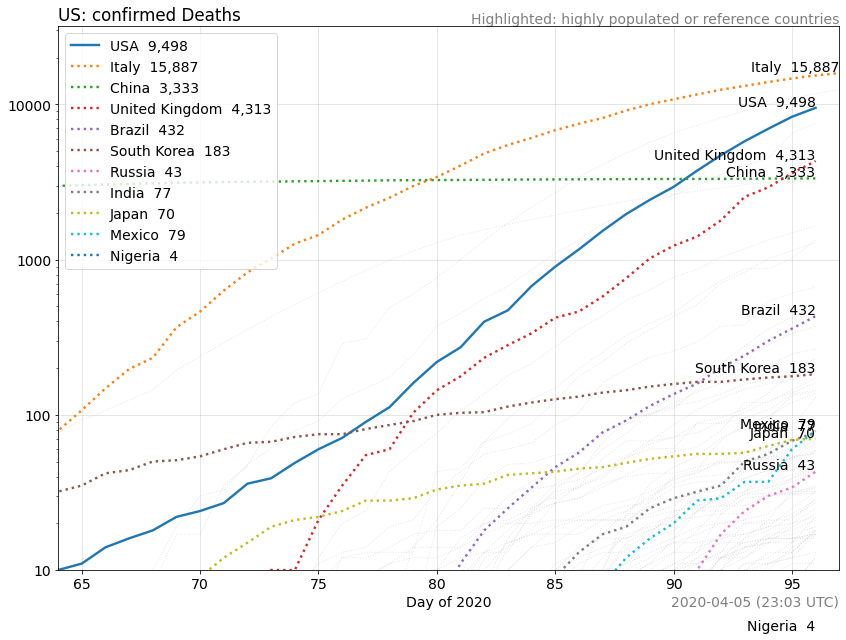

In [3]:
ep.scatter_plot_by_series(
    df_fused_daily,
    x_key='X', y_key='Deaths',
    series_key='CountryName', series_names=ranked_countries_by_confirmed_cases['CountryName'],
    y_log=True,
    series_is_secondary=lambda df: df['CountryName'].any() not in highlight_countries,
    series_secondary_width=1,
    bounds=[64, None, 10, None],
    data_labels="legend", data_labels_align='right',
    line_style_non_first_series='dotted',
    title='US: confirmed Deaths',
    label_x="Day of 2020",
    stamp_1='Highlighted: highly populated or reference countries'
)

### Table for US Aggregate data
Last 10 days of aggregated data.

In [4]:
df_fused_daily[df_fused_daily['CountryCode'] == 'US'][-10:]

,Date,X,CountryCode,CountryName,Confirmed,Deaths,Population,Death_rate,dateChecked,Negative,Infectious,Recovered,Hospitalized,Tampons,dConfirmed,dNegative,dDeaths,dHospitalized,dTampons,Tampon_hit_rate
9,2020-03-27,87,US,United States of America,99413.0,1530.0,329064917.0,1.539034,2020-03-27T20:00:00Z,527220.0,95461.0,2422.0,7532.0,626633.0,18678.0,88617.0,367.0,3277.0,107295.0,15.864629
8,2020-03-28,88,US,United States of America,118234.0,1965.0,329064917.0,1.661958,2020-03-28T20:00:00Z,617470.0,113121.0,3148.0,8725.0,735704.0,18821.0,90250.0,435.0,2955.0,109071.0,16.070865
7,2020-03-29,89,US,United States of America,139061.0,2428.0,329064917.0,1.745996,2020-03-29T20:00:00Z,692290.0,132572.0,4061.0,9922.0,831351.0,20827.0,74820.0,463.0,3038.0,95647.0,16.727110
6,2020-03-30,90,US,United States of America,160530.0,2939.0,329064917.0,1.830810,2020-03-30T20:00:00Z,784324.0,153031.0,4560.0,12147.0,944854.0,21469.0,92034.0,511.0,2902.0,113503.0,16.989926
5,2020-03-31,91,US,United States of America,184683.0,3746.0,329064917.0,2.028340,2020-03-31T20:00:00Z,864201.0,175271.0,5666.0,14236.0,1048884.0,24153.0,79877.0,807.0,4357.0,104030.0,17.607571
4,2020-04-01,92,US,United States of America,210816.0,4700.0,329064917.0,2.229432,2020-04-01T20:00:00Z,939190.0,199032.0,7084.0,16223.0,1150006.0,26133.0,74989.0,954.0,4482.0,101122.0,18.331730
3,2020-04-02,93,US,United States of America,239099.0,5784.0,329064917.0,2.419082,2020-04-02T20:00:00Z,1028649.0,224729.0,8586.0,17157.0,1267748.0,28283.0,89459.0,1084.0,1507.0,117742.0,18.860136
2,2020-04-03,94,US,United States of America,271988.0,6962.0,329064917.0,2.559672,2020-04-03T20:00:00Z,1124874.0,254604.0,10422.0,19926.0,1396862.0,32889.0,96225.0,1178.0,3342.0,129114.0,19.471358
1,2020-04-04,95,US,United States of America,305755.0,8314.0,329064917.0,2.719171,2020-04-04T20:00:00Z,1318052.0,284657.0,12784.0,22158.0,1623807.0,33767.0,193178.0,1352.0,2411.0,226945.0,18.829516
0,2020-04-05,96,US,United States of America,332308.0,9498.0,329064917.0,2.858192,2020-04-05T20:00:00Z,1429742.0,308324.0,14486.0,23061.0,1762050.0,26553.0,111690.0,1184.0,2970.0,138243.0,18.859170


## US States Charts

The following charts are for Confirmed cases. The first represents the total number of people declared 'Positive' (which can happen even after death). Note that the statistics do not include non-observable numbers such as deaths that are now tested for the virus or people that had low symptoms and did not get tested.


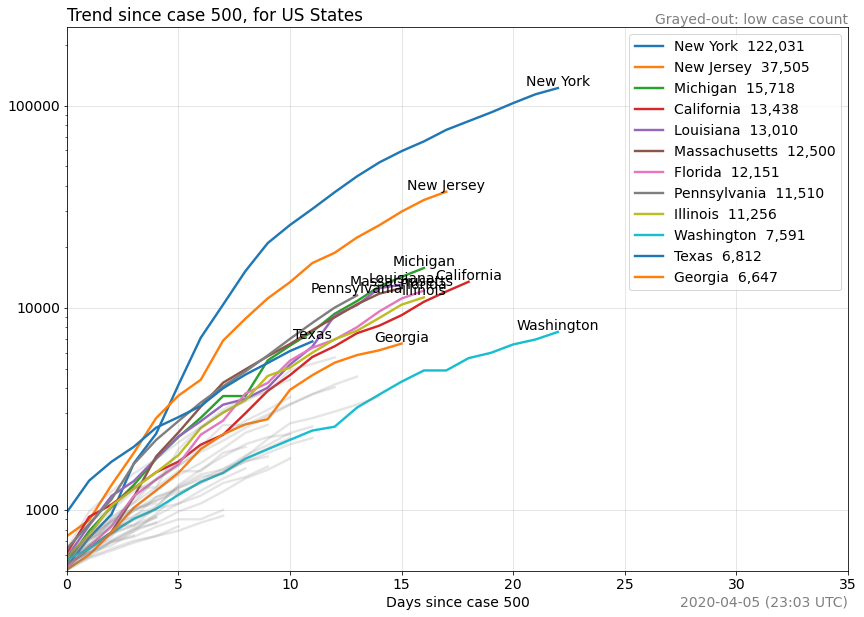

In [5]:
# states with the highest Confirmed
regions_by_cases = ep.rank_data_by_metric(df_us_states_daily, metric='Confirmed', unique_key='RegionName')
confirmed_top_count = regions_by_cases['Confirmed'].iloc[0].astype(int)
confirmed_sec_threshold = round(confirmed_top_count / 20).astype(int)
secondary_function = lambda df: df['Confirmed'].iloc[-1] < confirmed_sec_threshold

# [plot] Days sice Case 500, log
case_intersection = 500
ep.scatter_plot_by_series(
    df_us_states_daily,
    x_key='X', y_key='Confirmed',
    series_key='RegionName', series_names=regions_by_cases['RegionName'],
    series_is_secondary=secondary_function,
    shift_x_to_intersect_y=case_intersection,
    y_log=True,
    bounds=[None, (el.date_to_day_of_year(datetime.now()) - 66) * 1.5, None, None],
    data_labels="series", data_labels_align="center",
    title='Trend since case ' + str(case_intersection) + ', for US States',
    label_x='Days since case ' + str(case_intersection),
    stamp_1="Grayed-out: low case count"
)

This chart tries to bring the curves together at case #500, to see the difference in regional behavior after hitting that infection size.

In [0]:
# [plot] Day of the year, all series, higher than 100
first_day = el.date_to_day_of_year(datetime(2020, 3, 6))
last_day = el.date_to_day_of_year(datetime.now())
ep.scatter_plot_by_series(
    df_us_states_daily,
    x_key='X', y_key='Confirmed',
    series_key='RegionName', series_names=regions_by_cases['RegionName'],
    series_is_secondary=secondary_function,
    series_secondary_width=1,
    y_log=True,
    bounds=[first_day, last_day, 100, None],
    data_labels="series", data_labels_align='right',
    title='Confirmed cases by US State, over time',
    label_x="Day of 2020",
    stamp_1="Grayed-out: low case count"
)

This chart shows the mortality rate, defined as: Deaths / Total Positives. There are multiple factors to take into account on the numerator (in particular non-attributed deaths) and on the denominator (for example low-symptomatic cases, and non-tested cases) so the real values for the death rates are probably different.

For now this is a baseline estimation given the numbers we have.

In [0]:
# Mortality
regions_by_death_rate = ep.rank_data_by_metric(df_us_states_daily, metric='Death_rate', unique_key='RegionName')
ep.scatter_plot_by_series(
    df_us_states_daily,
    x_key='X', y_key='Death_rate',
    series_key='RegionName', series_names=regions_by_death_rate['RegionName'],
    series_is_secondary=secondary_function, series_secondary_width=1,
    y_filter='expo',
    bounds=[80, None, 0, 10],
    legend_decimals=1, legend_suffix='%',
    data_labels="legend", data_labels_align='right',
    title="Death rate by US State, in the last weeks",
    label_x="Day of 2020", label_y="Reported deaths / Confirmed cases (percent)",
    stamp_1="Grayed-out: states with low case count yet"
)

### Tables for US Regions
States ranked by higher Confirmed cases.

In [0]:
regions_by_cases

All regions ranked by higher Mortality rates.

NOTE: when confirmed cases are low ('Confirmed') in the table below, the 'Death_rate' is not significant, so it's up to you to filter and interpret the data below.

In [0]:
regions_by_death_rate